In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json

%matplotlib inline

# Load the data

In [2]:
use_paper_data = True
if use_paper_data:
    print("Using Paper data")
    data = np.load(open("./data/split_data.npz", "rb"))
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
else:
    print("reloading data")
    X = np.zeros((10000,50))
    data_path = "./data/clipper-cifar"
    for i in range(5):
        feature = np.load(open(data_path + '/cifar_prob_features'+str(i+1)+'.npz.zip', 'r'))['arr_0']
        X[:,(i*10):(i+1)*10] = softmax(feature)
    y = np.load(open(data_path + '/targets.npz.zip', 'r'))['arr_0'].astype('int32')
    yhot = np.zeros((len(y), int(y.max()) +1))
    yhot[np.arange(len(y)), y[:,0]] = 1

    train_prop = 0.8
    ind = np.random.permutation(len(X))
    #ind = range(len(X))
    train_ind = ind[:int(len(X) * train_prop)]
    test_ind = ind[int(len(X) * train_prop):]

    X_train = X[train_ind,:]
    y_train = yhot[train_ind,:]

    X_test = X[test_ind, :]
    y_test = yhot[test_ind,:]
    print X_test.shape, y_test.shape

Using Paper data


# Test individual models

In [3]:
def predict(w, x):
    (n,kd) = x.shape
    k = len(w)
    d = kd/k
    Z = np.swapaxes(np.reshape(x, [n,k,d]),1,2)
    return np.reshape(Z.dot(w), [n,d])

def compute_accuracy(yhat, y):
    return np.mean(np.argmax(yhat,1) == np.argmax(y,1))


In [91]:
k = 5
baseline_accuracy = np.zeros(5)
for i in range(k):
    w = np.zeros(k)
    w[i] = 1.
    yhat = predict(w, x_test)
    baseline_accuracy[i] = compute_accuracy(yhat, y_test)
    print baseline_accuracy[i]

0.7575
0.654
0.832
0.54
0.9085


# Try Scikit Learn

In [5]:
import sklearn.linear_model as lm

Fit a multinomial loss logistic regression (cross-entropy) model on all 50 dimensions:

In [6]:
model = lm.LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(x_train, np.argmax(y_train,1))
np.mean(model.predict(x_test) == np.argmax(y_test,1))

0.91149999999999998

# Try  Tensorflow to constrain to ensemble with just k=5 parameters

In [7]:
k = 5
(n,kd) = x_train.shape
d = kd/k
assert len(y_train) == n

In [8]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1, dtype=tf.float32))
def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape, dtype=tf.float32))

Reshaping data to be n matrices (d,k)

In [9]:
z_train = np.swapaxes(np.reshape(x_train, [n,k,d]),1,2)
z_test = np.swapaxes(np.reshape(x_test, [len(x_test),k,d]),1,2)

reproducing the earlier predictions

In [10]:
z = tf.placeholder(tf.float32, shape=(None, d, k))
w = weight_variable([k])
r = tf.reduce_sum(tf.mul(z,w),reduction_indices=[2])

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

k = 5
for i in range(k):
    wv = np.zeros(k)
    wv[i] = 1.
    yhat = sess.run(r, feed_dict={z: z_test, w: wv})
    ac = compute_accuracy(yhat, y_test)
    print ac


0.7575
0.654
0.832
0.54
0.9085


In [11]:
z = tf.placeholder(tf.float32, shape=(None, d, k))
w = weight_variable([k])
b = bias_variable([d])
q = tf.reduce_sum(tf.mul(z,w),reduction_indices=[2]) + b
y = tf.nn.softmax(q)
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

(0.91500000000000004, 0.89449999999999996)


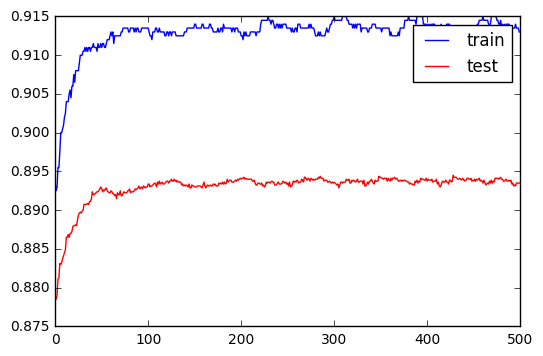

In [12]:
train_step = tf.train.GradientDescentOptimizer(1.0).minimize(cross_entropy)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
n = len(z_train)
ind = np.random.permutation(n)
def batch_ind(i):
    bs = 100
    index = i % int(np.ceil(float(n) / bs))
    low = index * bs
    high = np.min([(index + 1) * bs, n])
    return ind[low:high]

niter = 500
test_acc = np.zeros(niter)
train_acc = np.zeros(niter)
for i in range(niter):
#         with sess.as_default():
#             print(W.eval())
    sess.run(train_step, feed_dict={z: z_train[batch_ind(i),:,:], y_: y_train[batch_ind(i),:]})
    train_acc[i] = sess.run(accuracy, feed_dict={z: z_train, y_: y_train})
    test_acc[i] = sess.run(accuracy, feed_dict={z: z_test, y_: y_test})

plt.plot(np.arange(niter), test_acc, 'b', np.arange(niter), train_acc, 'r')
plt.legend(["test", "train"])
print(test_acc.max(), train_acc.max())

In [13]:
best_w= np.array(sess.run(w))
print(best_w)
compute_accuracy(predict(best_w, x_test), y_test)

[ 0.83282006  0.63355911  1.9974072   0.47542179  3.17676187]


0.91300000000000003

**confidence prediction**

In [14]:
# w_best = np.array([0.06791864,0,0.43857924,0.,0.49350212])
w_best = best_w
print(w_best)

[ 0.83282006  0.63355911  1.9974072   0.47542179  3.17676187]


In [15]:
yhat = np.zeros([len(y_test),k],dtype='int32')
for i in range(k):
    w = np.zeros(k)
    w[i] = 1.0
    yhat[:,i] = np.argmax(predict(w, x_test),axis=1)

agree = np.array([np.bincount(labels).max() for labels in yhat])
acc = np.argmax(predict(w_best, x_test),axis=1) == np.argmax(y_test,axis=1)


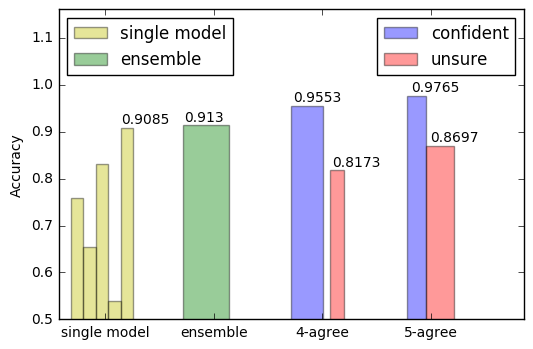

In [20]:
fig, ax = plt.subplots()

four_agree_c = (np.around(np.mean(acc[agree >= 4]), 4), np.mean(agree >= 4))  ## the second is the proportion
four_agree_u = (np.around(np.mean(acc[agree < 4]), 4),  np.mean(agree < 4))

five_agree_c = (np.around(np.mean(acc[agree >= 5]),4), np.mean(agree >= 5))  ## the second is the proportion
five_agree_u = (np.around(np.mean(acc[agree < 5]), 4),  np.mean(agree < 5))


bar_width = 0.3
opacity = 0.4

thin_bar = 0.08
original_acc = [0.7575, 0.654, 0.832, 0.54, 0.9085]

for i in range(len(original_acc)):
    if i == 0:
        rects0 = plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y', label='single model')
    else:
        plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y')

    
rects1 = plt.bar(0.5+bar_width, np.mean(acc), bar_width, alpha=opacity, color='g', label='ensemble')
rects2 = plt.bar(1.2+bar_width, four_agree_c[0], four_agree_c[1]*bar_width,  alpha=opacity, color='b', label='confident')
rects3 = plt.bar(1.15+bar_width*2, four_agree_u[0], four_agree_u[1]*bar_width,  alpha=opacity, color='r', label='unsure')
plt.bar(1.95+bar_width, five_agree_c[0], five_agree_c[1]*bar_width,  alpha=opacity, color='b')
plt.bar(2.07+bar_width, five_agree_u[0], five_agree_u[1]*bar_width,  alpha=opacity, color='r')


plt.ylabel('Accuracy')
ax.set_ylim([0.5,1.16])

first_legend = plt.legend(handles=[rects0,rects1], loc=2)
axx = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[rects2,rects3], loc=1)


ind = np.array([0.3,1,1.7,2.4])
plt.xticks(ind, ('single model', 'ensemble', '4-agree', '5-agree'))

cnt = 0
for p in ax.patches:
    if cnt >= 4:
        ax.annotate(str(float(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.01))
    cnt += 1
plt.savefig('ensemble_confidence_plot.pdf')

# Exp3 vs Exp4 Experiment

In [189]:
features = np.copy(np.reshape(x_train[1], [5, 10]))
ind = np.argmax(features,1)
features[np.arange(k), ind]

array([ 0.99832373,  0.4060303 ,  0.97793805,  0.39976268,  1.        ])

In [197]:
eps = 0.00000001
def exp3(eta, w, features, y_true):
    (k, d) = features.shape    
    # p_model = (1. - eta) * w / float(np.sum(w)) + eta / float(k)
    p_model = w / np.sum(w) 
    model = np.random.choice(np.arange(k), p=p_model)
    # pred = np.random.choice(np.arange(d), p=features[model])
    pred = np.argmax(features[model])
    loss = np.zeros(k)
    loss[model] = float(pred != y_true) / p_model[model]
        
    # w_new = w * np.exp(eta * reward / k )
    w_new = w * np.exp(-eta * loss)
    w_new = w_new / np.sum(w_new) 
    return (w_new, pred)


def exp4(eta, w, features, y_true):
    (k, d) = features.shape    
    p_model = w / np.sum(w)
    # p_label = (1. - eta) * p_model.dot(features) + eta / d
   
    p_label = p_model.dot(features)
    pred = np.random.choice(np.arange(d), p = p_label)
    
    loss = np.zeros(d)
    loss[pred] = float(pred != y_true) / p_label[pred]

    y = features.dot(loss)
    # w_new = w * np.exp(-eta * y / d)
    w_new = w * np.exp(-eta * y)
    w_new = w_new / np.sum(w_new) 
    return (w_new, pred)



def exp4a(eta, w, features, y_true):
    (k, d) = features.shape    
    p_model = w / np.sum(w)
    # p_label = (1. - eta) * p_model.dot(features) + eta / d
    f2 = np.zeros([k,d])
    f2[np.arange(k),np.argmax(features,1)] = 1.0
    p_label = p_model.dot(f2)
    pred = np.random.choice(np.arange(d), p = p_label)
    
    loss = np.zeros(d)
    loss[pred] = float(pred != y_true) / p_label[pred]

    y = f2.dot(loss)
    # w_new = w * np.exp(-eta * y / d)
    w_new = w * np.exp(-eta * y)
    w_new = w_new / np.sum(w_new) 
    return (w_new, pred)



def wfixed(m, w, features, y_true):
    pred = pred = np.argmax(features[m])
    return (w, pred)

In [204]:
def experiment(T=2000, failures = [], policies = []):
    k = 5
    (n, kd) = x_train.shape
    d = kd / k
    
    w = np.ones([len(policies), k])
    loss = np.zeros([T, len(policies)])

    for t in range(T):
        ind = np.random.randint(n)
        
        features = np.copy(np.reshape(x_train[ind], [k, d]))
        for ((start, end), m) in failures:
            if (t >= start) and (t <= end):
                features[m] = np.random.dirichlet(np.ones(d))
            
        ytrue = np.argmax(y_train[ind])

        for p in range(len(policies)):
            (w[p], pred) = policies[p](w[p], features, ytrue)
            loss[t, p] = float(pred != ytrue)
    return loss

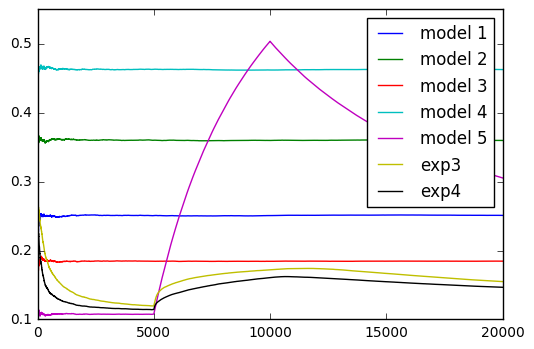

In [242]:
failures = [((5000, 10000), 4),]
policies = [
            (lambda w, f, yt: wfixed(0,w,f,yt)), (lambda w, f, yt: wfixed(1,w,f,yt)),
            (lambda w, f, yt: wfixed(2,w,f,yt)), (lambda w, f, yt: wfixed(3,w,f,yt)), 
            (lambda w, f, yt: wfixed(4,w,f,yt)),
            (lambda w, f, yt: exp3(0.05,w,f,yt)), (lambda w, f, yt: exp4a(0.2,w,f,yt))]
np.random.seed(1982)

ntrials = 50
T = 20000
loss = experiment(T = T, failures = failures, policies = policies)
for r in range(1, ntrials):
    loss += experiment(T = T, failures = failures, policies = policies)

loss = loss / float(ntrials)    
avg_loss = np.cumsum(loss, 0) / np.tile(np.arange(len(loss)).T + 1.0,(loss.shape[1],1)).T
plt.plot(avg_loss)
plt.legend(['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'exp3', 'exp4'])

In [249]:
plt.subplots?

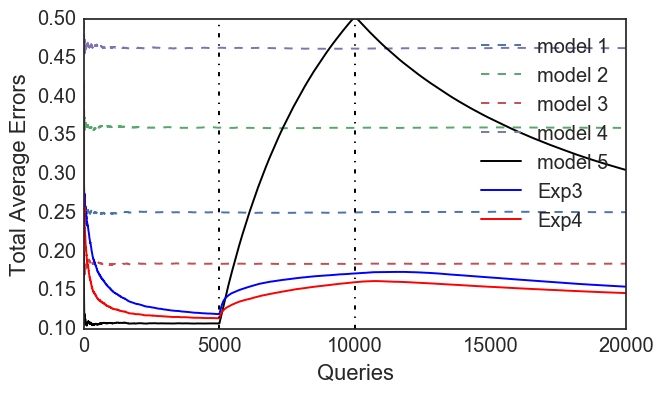

In [263]:
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8,)


fig, ax = plt.subplots(figsize=(7,4))
T = len(avg_loss)
for i in range(5):
    if i == 4:
        ax.plot(avg_loss[:,i], 'k', label='model '+str(i+1))
    else:
        ax.plot(avg_loss[:,i], '--', label='model '+str(i+1))
ax.plot(avg_loss[:,5], 'b-' , label='Exp3')
ax.plot(avg_loss[:,6], 'r-' , label='Exp4')
plt.xlabel('Queries')
plt.ylabel('Total Average Errors')
plt.axvline(x=5000,color='black',linestyle='-.')
plt.axvline(x=10000,color='black',linestyle='-.')
ax.set_ylim([0.1,.5])
# ax.legend(loc=1)
ax.legend(loc=(0.72,0.29))
plt.savefig('cifar10-exp3-drift.pdf')


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(avg_loss)), avg_loss, label='exp3-vs-exp4-drift')
for i in range(5):
    ax.plot(range(len(avg_drift)), np.ones((len(avg_drift),))*original_acc[i], '--',label='model'+str(i+1))
plt.axvline(x=1000,color='black',linestyle='--')
ax.annotate('failure in model5', xy=(1001, 0.9), xytext=(1300, 0.92),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.xlabel('queries')
plt.ylabel('accuracy')
ax.set_ylim([0.5,1])
ax.legend(loc=4)
plt.savefig('cifar10-exp3-drift.pdf')